In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit

from sklearn.decomposition import PCA
import sqlite3 as sql
import warnings



**Load the features data, these are popular trend following features used in prior literature, this notebook assumes you have the pickle file residual_returns.pkl saved in the root directory, you can download this file from the OneDrive**

In [27]:
feats = load_features_data()
feats.tail()


ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 15        3.398228  0.010781 -0.018600 -0.010795 -0.003738   
           16        3.080426  0.010995 -0.020717 -0.020520 -0.008363   
           17        4.019482  0.011090 -0.018740 -0.010313  0.002589   
           18       10.257413  0.011017 -0.014164 -0.005898  0.047696   
           19        3.623791  0.010924  0.001962  0.001796  0.001793   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 15      -0.010729  0.088150  0.044806      -1.725280   
           16       0.004148  0.084058 -0.022932      -1.884206   
           17      -0.059504 -0.079410 -0.113126      -1.689814   
           18       0.064581  0.131315  0.153882      -1.285637   
           19       0.111935  0.238240  0.080132       0.179593   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 15            -0.447788  ...                 0.138748   
           16            -0.834625  ...                 0.097605   
           17            -0.415871  ...                 0.101396   
           18            -0.239423  ...                 0.483758   
           19             0.073513  ...                 0.173823   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 15                       0.259889                0.574767   
           16                       0.322557                0.642906   
           17                       0.006033               -0.415118   
           18                       0.557877                0.717302   
           19                       0.503369                0.849991   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 15                 -0.202834             -0.023611   
           16                 -0.195628             -0.024484   
           17                 -0.213701             -0.034735   
           18                 -0.229808             -0.042143   
           19                 -0.236460             -0.033288   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 15                  0.229975              0.324046        NaN   
           16                  0.209541              0.330980        NaN   
           17                  0.168224              0.327998        NaN   
           18                  0.153079              0.316662        NaN   
           19                  0.163940              0.359519        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 15          NaN        NaN  
           16          NaN        NaN  
           17          NaN        NaN  
           18          NaN        NaN  
           19          NaN        NaN  

[5 rows x 89 columns]

count    125019.000000
mean          0.029297
std           1.228097
min         -18.536928
25%          -0.597784
50%           0.062029
75%           0.686203
max          70.166324
Name: target, dtype: float64
count    125019.000000
mean          0.028428
std           1.201198
min         -10.000000
25%          -0.597784
50%           0.062029
75%           0.686203
max          10.000000
Name: target, dtype: float64


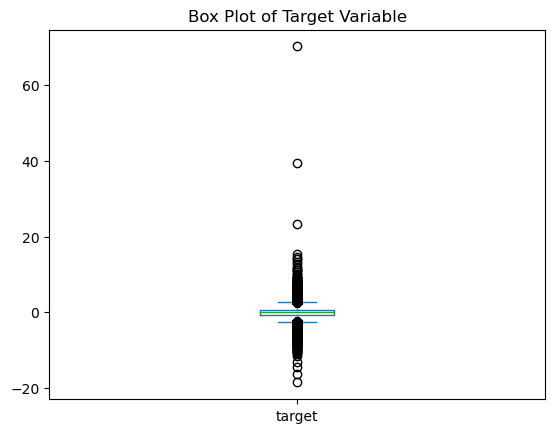

In [28]:
# distribution of tragets
feats['target'].plot(kind='box', title="Box Plot of Target Variable")
print(feats['target'].describe())

# clip the three large outliers
feats['target'] = feats['target'].clip(-10., 10.)
print(feats['target'].describe())

<Axes: >

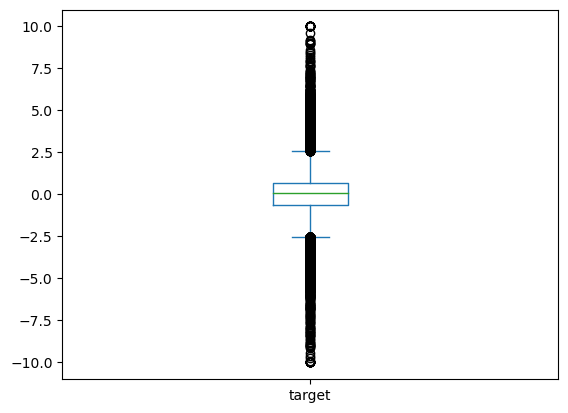

In [29]:
feats['target'].plot(kind='box')

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [30]:
features = [f for f in feats.columns if f.startswith("feature")]
target = ["target"]
lag_feats = [f for f in feats.columns if f.startswith('lag')]

# make a new feature vector for features + lags
all_feats = features + lag_feats + target
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)



Shape of features (119900, 79)


**Break out X and y and set up cross-validation, define models**

In [31]:
X = feats[all_feats].copy()

# set some configs
N_ITER=75

# Random Forest Regressor
baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               random_state=49, 
                               n_jobs=-1)

# simple-grid
grid = {'rf__n_estimators': np.arange(100, 2000, 100),
        'rf__max_depth': [3, 6, 9, 12],
        'rf__max_features': [int(1), 'sqrt'],
        'rf__min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}
paramsRF = ParameterSampler(n_iter=N_ITER, param_distributions=grid)


rfPipe = Pipeline(steps=[('scaler', RobustScaler()), ('rf',baseRF)])
rfPipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                           ('selector', SelectFromModel(baseRF, threshold='mean')),
                           ('rf',baseRF)])

# Elastic Net Regressor
net = ElasticNet(max_iter=1000)
eNetPipe = Pipeline(steps=[('scaler', RobustScaler()), ('net', net)])
eNetPipePCA = Pipeline(steps=[('scaler', RobustScaler()),
                              ('pca', PCA(n_components=.95)),
                              ('net', net)])

eNet_grid = {'net__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
             'net__l1_ratio': np.arange(0.10, .90, 0.01)}

paramsNet = ParameterSampler(n_iter=N_ITER, param_distributions=eNet_grid)

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(16, 8),
                   random_state=49,
                   shuffle=False,
                   max_iter=10,
                   early_stopping=False,
                   learning_rate='constant')

mlp_pipe = Pipeline(steps=[('scaler', RobustScaler()), ('mlp', mlp)])
mlp_pipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                             ('selector', SelectFromModel(baseRF, threshold='mean')),
                             ('mlp', mlp)])
mlp_grid = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001, .01],
            'mlp__batch_size': [32, 64, 128, 256],
            'mlp__max_iter': [25, 50, 75, 100, 150],
            'mlp__hidden_layer_sizes': [(12, 6), (16, 8), (6, 3), (4, 2), (32, 16)],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01]}
mlp_sampler = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid)


# make the hidden layer sizes a little bit smaller here
mlp_grid2 = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001, .01],
            'mlp__batch_size': [32, 64, 128, 256],
             'mlp__max_iter': [25, 50, 75, 100, 150],
            'mlp__hidden_layer_sizes': [(6, 3), (4, 2), (8, 4)],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01]}
mlp_sampler2 = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid2)

# append the models
models = [(eNetPipe, paramsNet, 'preds_eNet'),
          (eNetPipePCA, paramsNet, 'preds_eNetPCA'),
          (rfPipe, paramsRF, 'preds_RF'),
          (rfPipeFS, paramsRF, 'preds_RF_FS')]


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [32]:
def train_single_model(model, sampler, model_name):
    predictions = []
    scores = []
    res = []
    for c, (train, test) in tqdm(enumerate(get_cv_splits(X, split_length=252*5))):
        # break out X and y train, test
        X_train, y_train = train[features], train[target] 
        X_test, y_test = test[features], test[target]

        # hyper-param loop
        X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
        print(X_train2.shape, X_val.shape)

        # inner loop for parameter tuning
        gscv_scores = {'scores': [], 'grid':[]}
        for k, p in enumerate(sampler):
            model.set_params(**p)
            try:
                model.n_jobs=-1
            except Exception as e:
                pass
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
            _pred = model.predict(X_val)
            _score = mean_squared_error(y_val, _pred)
            gscv_scores['scores'].append(_score)
            gscv_scores['grid'].append(p)
            print(f'Iter: {k}: Score: {_score}')

        # now fit the best model
        best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
        _res = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1) # this should be the best score in the GSCV
        _res[f'split_{c}'] = c
        res.append(_res)
        print(pd.DataFrame(gscv_scores).sort_values(by='scores').head(1))
        print(f'Best Model: {best_model}')
        best_model = model.set_params(**best_model)
        best_model.n_jobs=-1
        best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
        preds = best_model.predict(X_test)

        # append the predictions
        predictions.append(pd.Series(index=y_test.index, data=preds))
       
        # score
        scores.append(mean_squared_error(y_test, preds))

    # predictions
    predictions = pd.concat(predictions).to_frame(model_name)
    return predictions, pd.concat(res)

# train all models selected
predictions = []
for model in models:
    out = train_single_model(model[0], model[1], model[2])
    out[1].to_pickle(f'{model[2]}_results.pkl')
    predictions.append(out[0])

# concat the predictions by columns
predictions = pd.concat(predictions, axis=1)

0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5007119720081903
Iter: 1: Score: 1.5044502315548194
Iter: 2: Score: 1.50507159802543
Iter: 3: Score: 1.5051210859824509
Iter: 4: Score: 1.505101805235373
Iter: 5: Score: 1.5050364565246046
Iter: 6: Score: 1.5050545086589924
Iter: 7: Score: 1.5051208003364003
Iter: 8: Score: 1.5051201329422386
Iter: 9: Score: 1.505085715564782
Iter: 10: Score: 1.5051243208085903
Iter: 11: Score: 1.5018327142018706
Iter: 12: Score: 1.5051226070303025
Iter: 13: Score: 1.5051008515128061
Iter: 14: Score: 1.5051212749743392
Iter: 15: Score: 1.5007348313645594
Iter: 16: Score: 1.5013659775819503
Iter: 17: Score: 1.5045469953049344
Iter: 18: Score: 1.5048310850505042
Iter: 19: Score: 1.5013103120418836
Iter: 20: Score: 1.5004673937471116
Iter: 21: Score: 1.505124988004698
Iter: 22: Score: 1.5050630775774998
Iter: 23: Score: 1.5051231785455175
Iter: 24: Score: 1.5044195786472407
Iter: 25: Score: 1.505081018415164
Iter: 26: Score: 1.5051037053489078
Iter: 27: Score: 1.

0it [00:09, ?it/s]


KeyboardInterrupt: 

**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

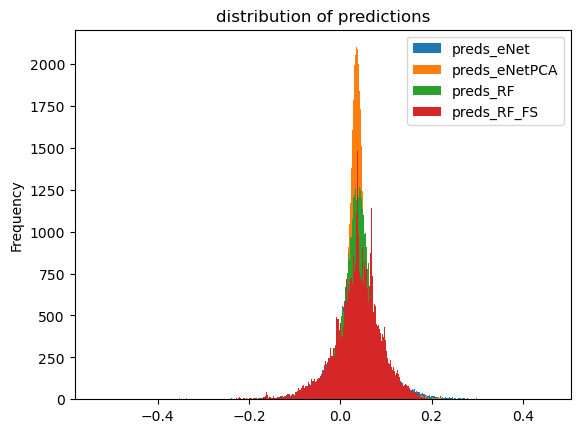

In [22]:
# We can see predictions go negative at about the 25% percentile, market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [23]:
# Bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

# get the prediction columns
pred_cols = [f for f in predictions.columns if f.startswith('preds_')]

def getRetsForStrat(predictions, pred_cols):
    ret_list = []
    for pred_col in pred_cols:
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='date')[pred_col].apply(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')).droplevel(0)
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='cluster')[f'{pred_col}_signalQ'].shift(1)
        rets = predictions.groupby(by=['date', f'{pred_col}_signalQ'])['1d_ret'].mean().unstack()
        rets.rename(columns={col: f'{pred_col}_Q_{col}' for col in rets.columns}, inplace=True)
        ret_list.append(rets)
    return ret_list

ret_breakouts = []
# get all the returns
all_rets = getRetsForStrat(predictions, pred_cols)
for one_ret in all_rets:
    print(get_returns_breakout(one_ret))
    ret_breakouts.append(get_returns_breakout(one_ret))
    print('#################################')

# stack the returns
stacked_strat_rets = pd.concat([r.stack().to_frame('ret') for r in all_rets]) # this can hopefully be the data used for streamlit
stacked_strat_rets_cumprod = (1+stacked_strat_rets.unstack()).cumprod()

# save to sqlite3 DB
conn = sql.connect("ml_results.db")

stacked_strat_rets_cumprod.columns = stacked_strat_rets_cumprod.columns.droplevel(0)
stacked_strat_rets_cumprod.to_sql('strategy_returns', conn, if_exists='replace', index=True)
pd.concat(ret_breakouts).to_sql("metrics_df", conn, if_exists='replace', index=True)

                 Annual_Return Annual_Volatility        DD       MDD  \
preds_eNet_Q_0.0      0.046733          0.211416  0.149953 -0.685632   
preds_eNet_Q_1.0      0.074199           0.21175  0.154089  -0.58988   
preds_eNet_Q_2.0      0.091024          0.211774   0.14581 -0.637034   
preds_eNet_Q_3.0      0.099995          0.221497  0.148825 -0.545804   

                    Sharpe   Sortino    Calmar ppct_postive_rets  
preds_eNet_Q_0.0  0.321315  0.453016   0.06816          0.541015  
preds_eNet_Q_1.0  0.444492  0.610824  0.125786           0.54482  
preds_eNet_Q_2.0  0.516817  0.750625  0.142888          0.541015  
preds_eNet_Q_3.0  0.540027  0.803723  0.183207          0.538266  
#################################
                    Annual_Return Annual_Volatility        DD       MDD  \
preds_eNetPCA_Q_0.0      0.061599          0.212574   0.14832 -0.652138   
preds_eNetPCA_Q_1.0      0.092937          0.211582  0.151696 -0.616212   
preds_eNetPCA_Q_2.0      0.069711           0

16

In [25]:
out[1]

[{'rf__n_estimators': 800,
  'rf__min_weight_fraction_leaf': 0.01,
  'rf__max_features': 1,
  'rf__max_depth': 3},
 {'rf__n_estimators': 300,
  'rf__min_weight_fraction_leaf': 0.005,
  'rf__max_features': 'sqrt',
  'rf__max_depth': 3},
 {'rf__n_estimators': 300,
  'rf__min_weight_fraction_leaf': 0.0,
  'rf__max_features': 'sqrt',
  'rf__max_depth': 3},
 {'rf__n_estimators': 200,
  'rf__min_weight_fraction_leaf': 0.045,
  'rf__max_features': 'sqrt',
  'rf__max_depth': 9}]